<h1>Project Workflow</h1>

<img src='https://i.ibb.co/fqgB6b7/image.png'> 

<h1>1- Project Objective</h1>

The electric power distribution problem is the distribution of electricity to different areas depends
on its sequential usage. But predicting the following demand of a specific area is difficult, as it varies with weekdays, holidays, seasons, weather, temperatures, etc. This project is to predict the electrical transformers' oil temperature based on long-term real-world data with high precision.

<h3>Dataset Description</h3>



| Field | Date | HUFL | HULL | MUFL | MULL | LUFL | LULL | OT |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Description | The recorded date | High UseFul Load | High UseLess Load | Middle UseFul Load | Middle UseLess Load | Low UseFul Load | Low UseLess Load | Oil Temperature (target) |

<h1>2-Data Preprocessing</h1>

In [1]:
# import libraries and packages
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score

In [2]:
# import dataset
# please download the dataset here: https://github.com/zhouhaoyi/ETDataset/tree/main/ETT-small
df = pd.read_csv("https://github.com/zhouhaoyi/ETDataset/raw/main/ETT-small/ETTh1.csv")
df['date'] = pd.to_datetime(df['date'])
df.head()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000


In [3]:
#check for null values 
df.isnull().sum()

date    0
HUFL    0
HULL    0
MUFL    0
MULL    0
LUFL    0
LULL    0
OT      0
dtype: int64

In [4]:
#drop duplicates 
df.drop_duplicates(inplace=True)

So we will work on exploring the Data first. To understand the useful Features and stuff. 

<h2>Encoding Cyclical Features </h2>



In [5]:
hours = df.date.dt.hour  # Extracting the hour from each timestamp. 

#print(df.date.dt.hour[0:25])

df['Sin_Hour'] = np.sin(2 * np.pi * df.date.dt.hour / max(df.date.dt.hour))
df['Cos_Hour'] = np.cos(2 * np.pi * df.date.dt.hour / max(df.date.dt.hour))



In [6]:
df

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT,Sin_Hour,Cos_Hour
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000,0.000000,1.000000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001,0.269797,0.962917
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001,0.519584,0.854419
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001,0.730836,0.682553
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000,0.887885,0.460065
...,...,...,...,...,...,...,...,...,...,...
17415,2018-06-26 15:00:00,-1.674,3.550,-5.615,2.132,3.472,1.523,10.904000,-0.816970,-0.576680
17416,2018-06-26 16:00:00,-5.492,4.287,-9.132,2.274,3.533,1.675,11.044000,-0.942261,-0.334880
17417,2018-06-26 17:00:00,2.813,3.818,-0.817,2.097,3.716,1.523,10.271000,-0.997669,-0.068242
17418,2018-06-26 18:00:00,9.243,3.818,5.472,2.097,3.655,1.432,9.778000,-0.979084,0.203456


<h1>3-Exploratory data analysis</h1> 

<h3> Statiscal Analysis </h3>

In [7]:
df.describe()

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT,Sin_Hour,Cos_Hour
count,17420.000000,17420.000000,17420.000000,17420.000000,17420.000000,17420.000000,17420.000000,17420.000000,17420.000000
mean,7.375141,2.242242,4.300239,0.881568,3.066062,0.856932,13.324672,0.000087,0.041475
std,7.067744,2.042342,6.826978,1.809293,1.164506,0.599552,8.566946,0.692282,0.720474
min,-22.705999,-4.756000,-25.087999,-5.934000,-1.188000,-1.371000,-4.080000,-0.997669,-0.990686
25%,5.827000,0.737000,3.296000,-0.284000,2.315000,0.670000,6.964000,-0.656025,-0.775711
50%,8.774000,2.210000,5.970000,0.959000,2.833000,0.975000,11.396000,0.000000,-0.068242
75%,11.788000,3.684000,8.635000,2.203000,3.625000,1.218000,18.079000,0.730836,0.682553
max,23.643999,10.114000,17.341000,7.747000,8.498000,3.046000,46.007000,0.997669,1.000000


<h3> Correlation </h3>

In [8]:
correlations = df.corr()['OT'].sort_values(ascending=False)
print(correlations)

OT          1.000000
HULL        0.224354
MULL        0.220004
LUFL        0.118836
LULL        0.067455
HUFL        0.059916
MUFL        0.050854
Cos_Hour   -0.031778
Sin_Hour   -0.080109
Name: OT, dtype: float64


<h3> Data Visualization </h3>

<h4> Distribution of Oil Temperature </h4>

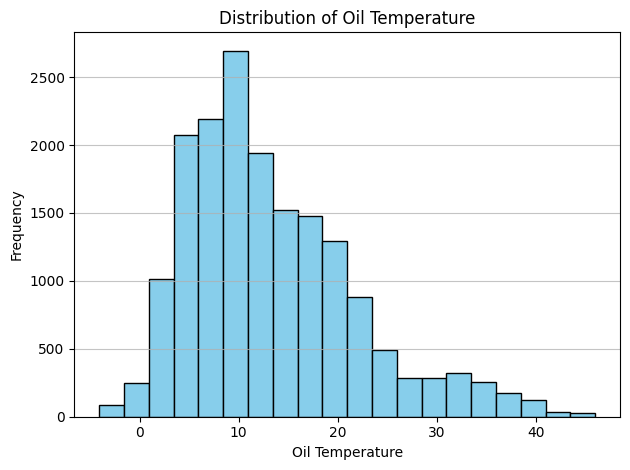

In [9]:
plt.hist(df['OT'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Oil Temperature')
plt.ylabel('Frequency')
plt.title('Distribution of Oil Temperature')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

<h4> Oil Temperature Over Time </h4>

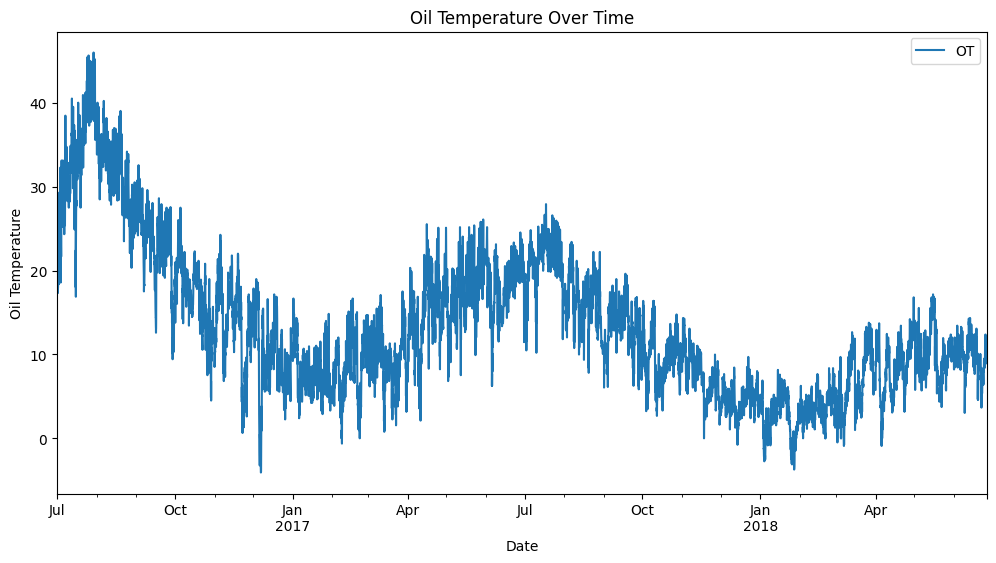

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))
df.plot(x='date', y='OT', ax=ax)
plt.title('Oil Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Oil Temperature')
plt.show()

<h4> Average Oil Temperature by Month </h4>

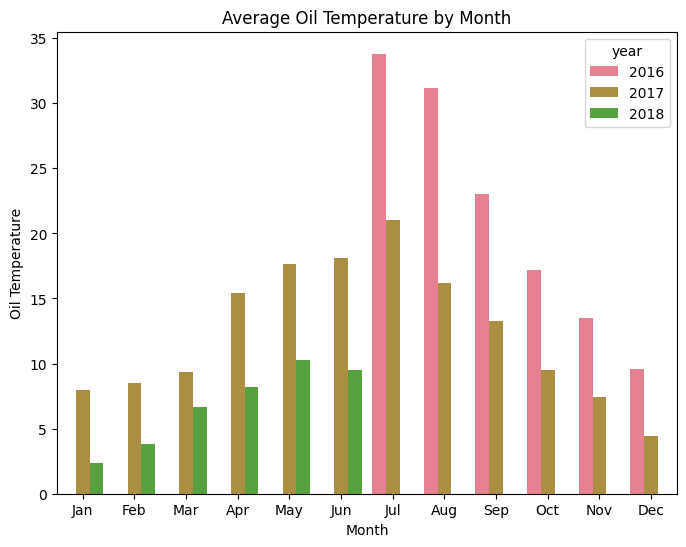

In [11]:
month_year_oil_temp = df[['date','OT']].copy()
month_year_oil_temp['month'] = month_year_oil_temp['date'].apply(lambda x: x.month)
month_year_oil_temp['year'] = month_year_oil_temp['date'].apply(lambda x: x.year)
month_year_oil_temp.head()
fig, ax = plt.subplots(figsize=(8,6))
sns.set_palette('husl')
sns.barplot(data=month_year_oil_temp, x="month", y="OT", hue="year", errorbar=None)
ax.set_xlabel('Month')
ax.set_ylabel('Oil Temperature')
ax.set_title('Average Oil Temperature by Month')
ax.set_xticks(range(12))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

<h4> Average Oil Temperature by Hour </h4>

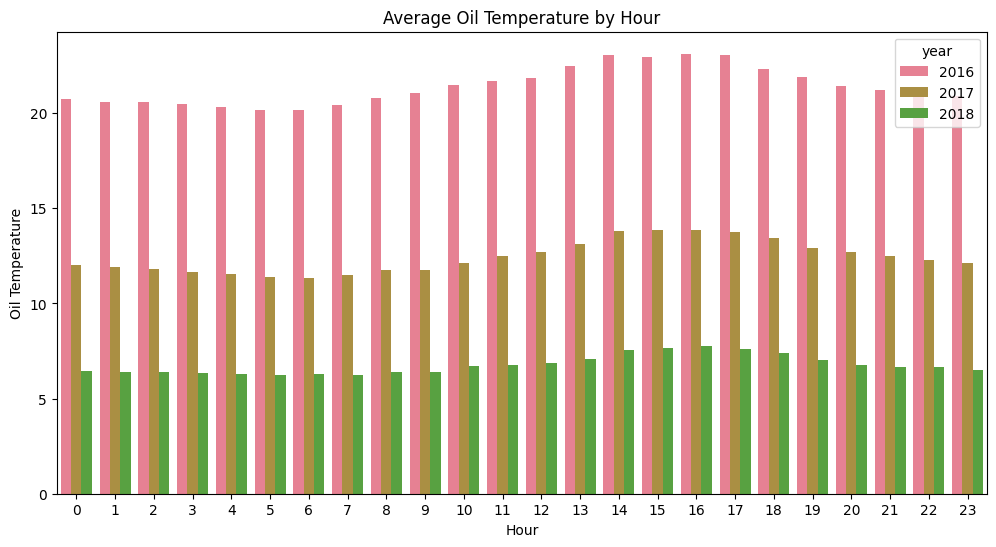

In [12]:
hour_year_oil_temp = df[['date','OT']].copy()
hour_year_oil_temp['hour'] = hour_year_oil_temp['date'].apply(lambda x: x.hour)
hour_year_oil_temp['year'] = hour_year_oil_temp['date'].apply(lambda x: x.year)
hour_year_oil_temp.head()
fig, ax = plt.subplots(figsize=(12,6))
sns.set_palette('husl')
sns.barplot(data=hour_year_oil_temp, x="hour", y="OT",hue="year", errorbar=None)
ax.set_xlabel('Hour')
ax.set_ylabel('Oil Temperature')
ax.set_title('Average Oil Temperature by Hour')
plt.show()

<h1>4-Modeling </h1>

<h2>Linear Regression (OLS)</h2>

In [13]:
#define X and y 
df.set_index('date',inplace=True)
X = df[['HUFL',	'HULL',	'MUFL',	'MULL',	'LUFL' ,'LULL','Sin_Hour',	'Cos_Hour']]
y = df['OT']
#split data
X_train , X_test , y_train , y_test =  train_test_split(X , y , test_size = 0.2 , shuffle=False )


In [14]:
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [15]:
 y_pred = reg.predict(X_test)

In [16]:
predicted_temp = pd.DataFrame(y_pred,index = X_test.index)

In [17]:

# get accuracy scores
print("Coef: ", reg.coef_)
print("R2 Score:", r2_score(y_test, predicted_temp))
print("MAE:", mean_absolute_error(y_test, predicted_temp))
print('MSE:', mean_squared_error(y_test, predicted_temp))
print('RMSE:', np.sqrt(mean_squared_error(y_test, predicted_temp)))

Coef:  [-0.15846081  1.040171    0.27782516  0.39294653  1.03623366 -0.18943622
 -2.22141693 -0.73881237]
R2 Score: -5.787345007995241
MAE: 8.01374426936779
MSE: 80.59663036655532
RMSE: 8.977562607220031


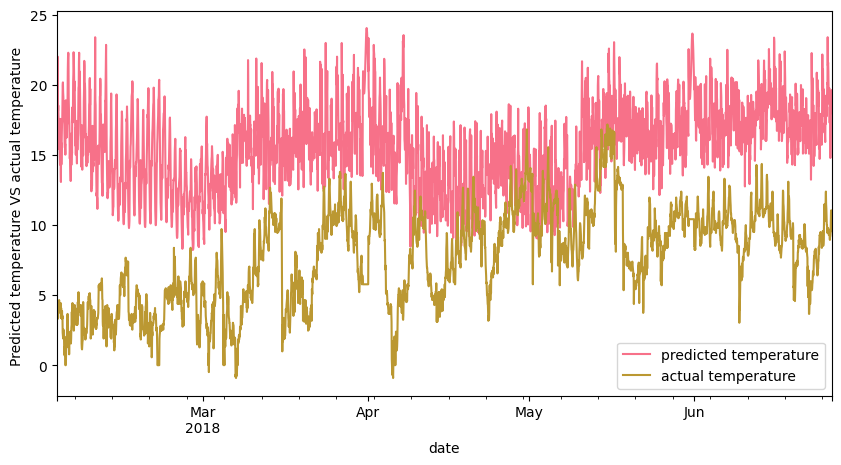

In [18]:
predicted_temp.plot(figsize=(10,5))
y_test.plot()
plt.legend(['predicted temperature','actual temperature'])  
plt.ylabel("Predicted temperature VS actual temperature ")  
plt.show()

<h3><h2>Linear Regression ( L2 Regularization)</h2></h3>

In [19]:
reg2 = Ridge()
reg2.fit(X_train, y_train)

Ridge()

In [20]:
 y_pred = reg2.predict(X_test)

In [21]:
predicted_temp = pd.DataFrame(y_pred,index = X_test.index)
# get accuracy scores
print("Coef: ", reg2.coef_)
print("R2 Score:", r2_score(y_test, predicted_temp))
print("MAE:", mean_absolute_error(y_test, predicted_temp))
print('MSE:', mean_squared_error(y_test, predicted_temp))
print('RMSE:', np.sqrt(mean_squared_error(y_test, predicted_temp)))

Coef:  [-0.15828341  1.03957818  0.27763059  0.39350883  1.03613185 -0.18881896
 -2.2209731  -0.73858085]
R2 Score: -5.787352804571865
MAE: 8.013784818491517
MSE: 80.59672294735142
RMSE: 8.977567763450823


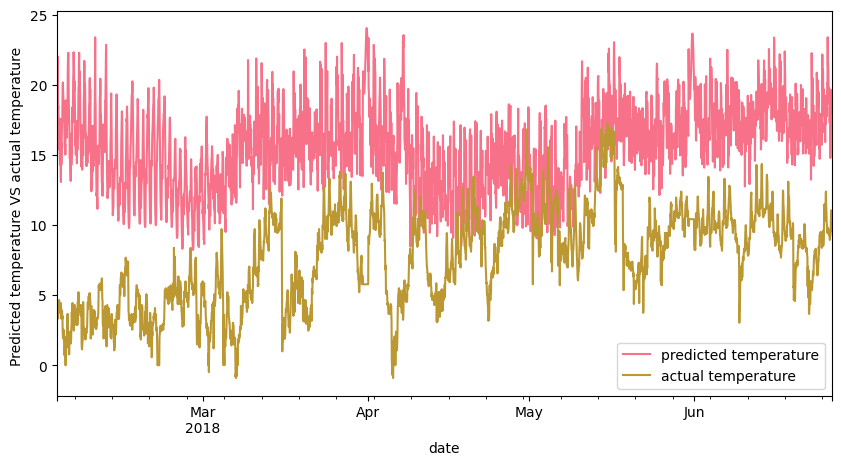

In [22]:
predicted_temp.plot(figsize=(10,5))
y_test.plot()
plt.legend(['predicted temperature','actual temperature'])  
plt.ylabel("Predicted temperature VS actual temperature ")  
plt.show()

<h3><h2>Support Vector Regression</h2></h3>

In [23]:
from sklearn.model_selection import GridSearchCV

#param = {'kernel' : ('linear','sigmoid'),'C' : [5,10],'degree' : [3,8],'coef0' : [0.01,10,0.5],'gamma' : ('auto','scale')}
svr = SVR()

#grid_search_svr = GridSearchCV(estimator = svr, param_grid = param,
#                     cv = 4, n_jobs = -1, verbose = 2)
svr.fit(X_train, y_train)

SVR()

MAE: 7.474814519821087
MSE: 72.51965733328552
RMSE: 8.515847423086297


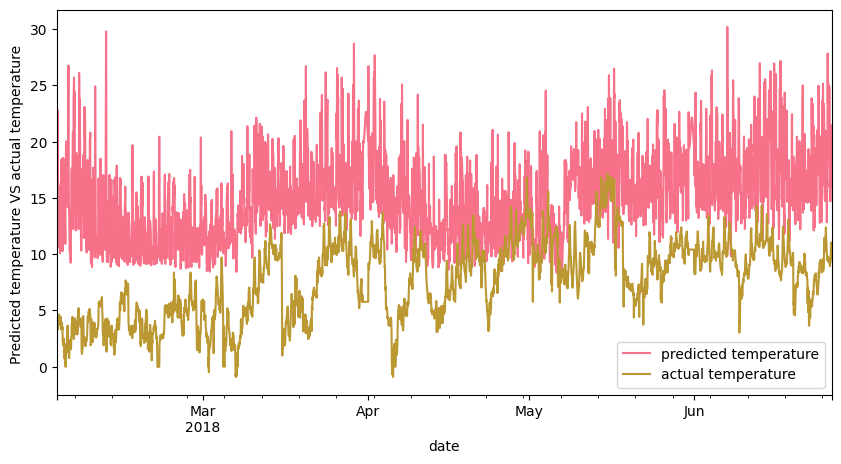

In [24]:

pred_temp_svr = svr.predict(X_test) 
pred_temp_svr = pd.DataFrame(pred_temp_svr,index=X_test.index)  

# get accuracy scores
print("MAE:", mean_absolute_error(y_test, pred_temp_svr))
print('MSE:', mean_squared_error(y_test, pred_temp_svr))
print('RMSE:', np.sqrt(mean_squared_error(y_test, pred_temp_svr)))

# We predict using the test data and plot actual vs predicted temp

pred_temp_svr.plot(figsize=(10,5))  
y_test.plot()
plt.legend(['predicted temperature','actual temperature'])  
plt.ylabel("Predicted temperature VS actual temperature ")  
plt.show()

<h2>LSTM</h2>

<h2>GRU</h2>

<h2>Dataset Shift</h2>

In order to check if our model generalizes well, we will check the model performance on different test data with different feature ditribution. 

ETTh1 and ETTh2 consist of data from 2 electricity transformers at 2 stations, including load, oil temperature.

ETTh1 is the dataset with which we are training the model.

ETTh2 will serve as dataset shift and we will be able to analyze how well our model can generalize forecasr for a dataset it has never seen befor. 

In [25]:
df_shift = pd.read_csv("https://github.com/zhouhaoyi/ETDataset/raw/main/ETT-small/ETTh2.csv")
df_shift['date'] = pd.to_datetime(df_shift['date'])

hours = df_shift.date.dt.hour  # Extracting the hour from each timestamp. 

#print(df.date.dt.hour[0:25])

df_shift['Sin_Hour'] = np.sin(2 * np.pi * df_shift.date.dt.hour / max(df_shift.date.dt.hour))
df_shift['Cos_Hour'] = np.cos(2 * np.pi * df_shift.date.dt.hour / max(df_shift.date.dt.hour))

df_shift.set_index('date',inplace=True)
X_shift = df_shift[['HUFL',	'HULL',	'MUFL',	'MULL',	'LUFL' ,'LULL','Sin_Hour',	'Cos_Hour']]
y_shift = df_shift['OT']
X_train , X_shift , y_train , y_shift =  train_test_split(X_shift , y_shift , test_size = 0.2 , shuffle=False )
df_shift
print(X_shift.shape[0])
print(X.shape[0])

3484
17420


In [26]:
# First we will calculate the distance between ETTh1, and ETTh2 using Maximum Mean Discrepancy
from scipy.spatial.distance import cdist
def mmd(X, Y):
    """
    Compute the Maximum Mean Discrepancy (MMD) between two datasets X and Y.
    """
    X = np.atleast_2d(X)
    Y = np.atleast_2d(Y)
    sigma2 = np.median(cdist(X, X, metric='euclidean')) ** 2
    KXX = np.exp(-cdist(X, X, metric='sqeuclidean') / sigma2)
    KYY = np.exp(-cdist(Y, Y, metric='sqeuclidean') / sigma2)
    KXY = np.exp(-cdist(X, Y, metric='sqeuclidean') / sigma2)
    return np.mean(KXX) + np.mean(KYY) - 2 * np.mean(KXY)
print(mmd(X, X_shift))

0.7135740634386284


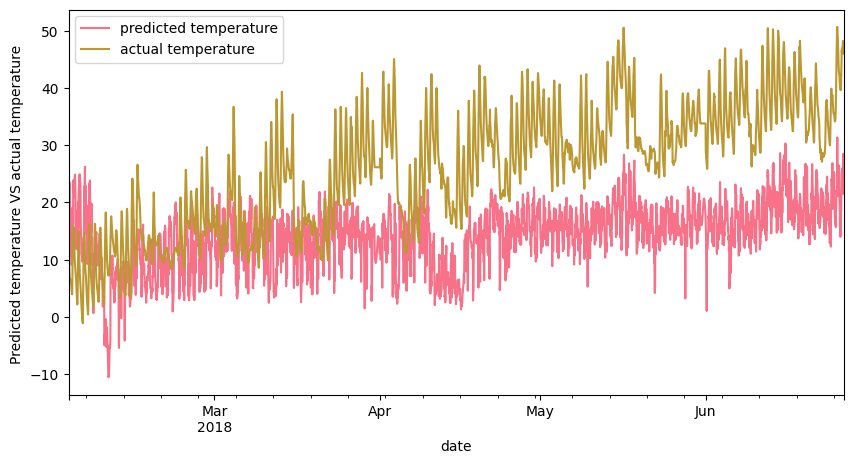

In [27]:
#Then we will test the model results for ETTh2, comparing to the actual labels.
y_pred_shift = reg.predict(X_shift) 
predicted_temp_shift = pd.DataFrame(y_pred_shift,index = X_shift.index)
predicted_temp_shift.plot(figsize=(10,5))
y_shift.plot()
plt.legend(['predicted temperature','actual temperature'])  
plt.ylabel("Predicted temperature VS actual temperature ")  
plt.show()


MAE: 9.057285104028779
MSE: 115.89418093297459
RMSE: 10.765415966555802


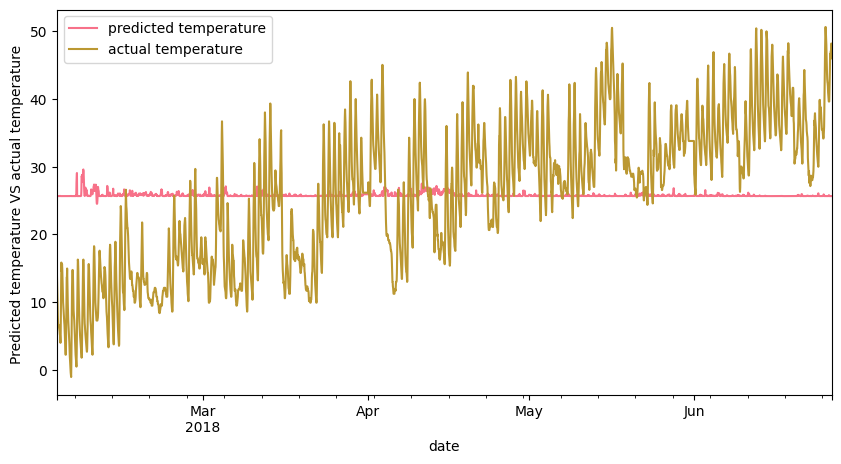

In [28]:
y_pred_shift = svr.predict(X_shift) 
predicted_temp_shift = pd.DataFrame(y_pred_shift,index = X_shift.index)
print("MAE:", mean_absolute_error(y_shift, predicted_temp_shift))
print('MSE:', mean_squared_error(y_shift, predicted_temp_shift))
print('RMSE:', np.sqrt(mean_squared_error(y_shift, predicted_temp_shift)))
predicted_temp_shift.plot(figsize=(10,5))
y_shift.plot()
plt.legend(['predicted temperature','actual temperature'])  
plt.ylabel("Predicted temperature VS actual temperature ")  
plt.show()

Additonally we can combine both datasets and isolate a specific year or month to create a dataset shift and check how our model deals with such abnormality. 